# Importing the necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
train_dir = '/content/drive/MyDrive/xray/Xray/train'
test_dir = '/content/drive/MyDrive/xray/Xray/test'
val_dir = '/content/drive/MyDrive/xray/Xray/val'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_data(data_dir, labels=['PNEUMONIA', 'NORMAL'], img_size=150):
    X = []
    y = []
    for label in labels:
        class_path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in tqdm(os.listdir(class_path), desc=f"Loading {label} images"):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (img_size, img_size))
                    X.append(img)
                    y.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0
    y = np.array(y)
    return X, y


In [ ]:
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

Loading NORMAL images: 100%|██████████| 234/234 [00:05<00:00, 42.94it/s] 


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(X_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.7998 - loss: 0.8652 - val_accuracy: 0.5000 - val_loss: 54.1566 - learning_rate: 0.0010
Epoch 2/12
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.8774 - loss: 0.3014 - val_accuracy: 0.5000 - val_loss: 13.5489 - learning_rate: 0.0010
Epoch 3/12
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9139 - loss: 0.2363
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9139 - loss: 0.2362 - val_accuracy: 0.5000 - val_loss: 58.0866 - learning_rate: 0.0010
Epoch 4/12
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9414 - loss: 0.1788 - val_accuracy: 0.5000 - val_loss: 24.0691 - learning_rate: 3.0000e-04
Epoch 5/12
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9471 - loss: 0.1432 - val_accuracy: 0.6250 - val_loss: 0.5611 - learning_rate: 3.0000e-04
Epoch 6/12
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9542 - l

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9364 - loss: 0.2205
Loss of the model is -  0.2689005434513092
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9364 - loss: 0.2205
Accuracy of the model is -  92.46794581413269 %


# Analysis after Model Training

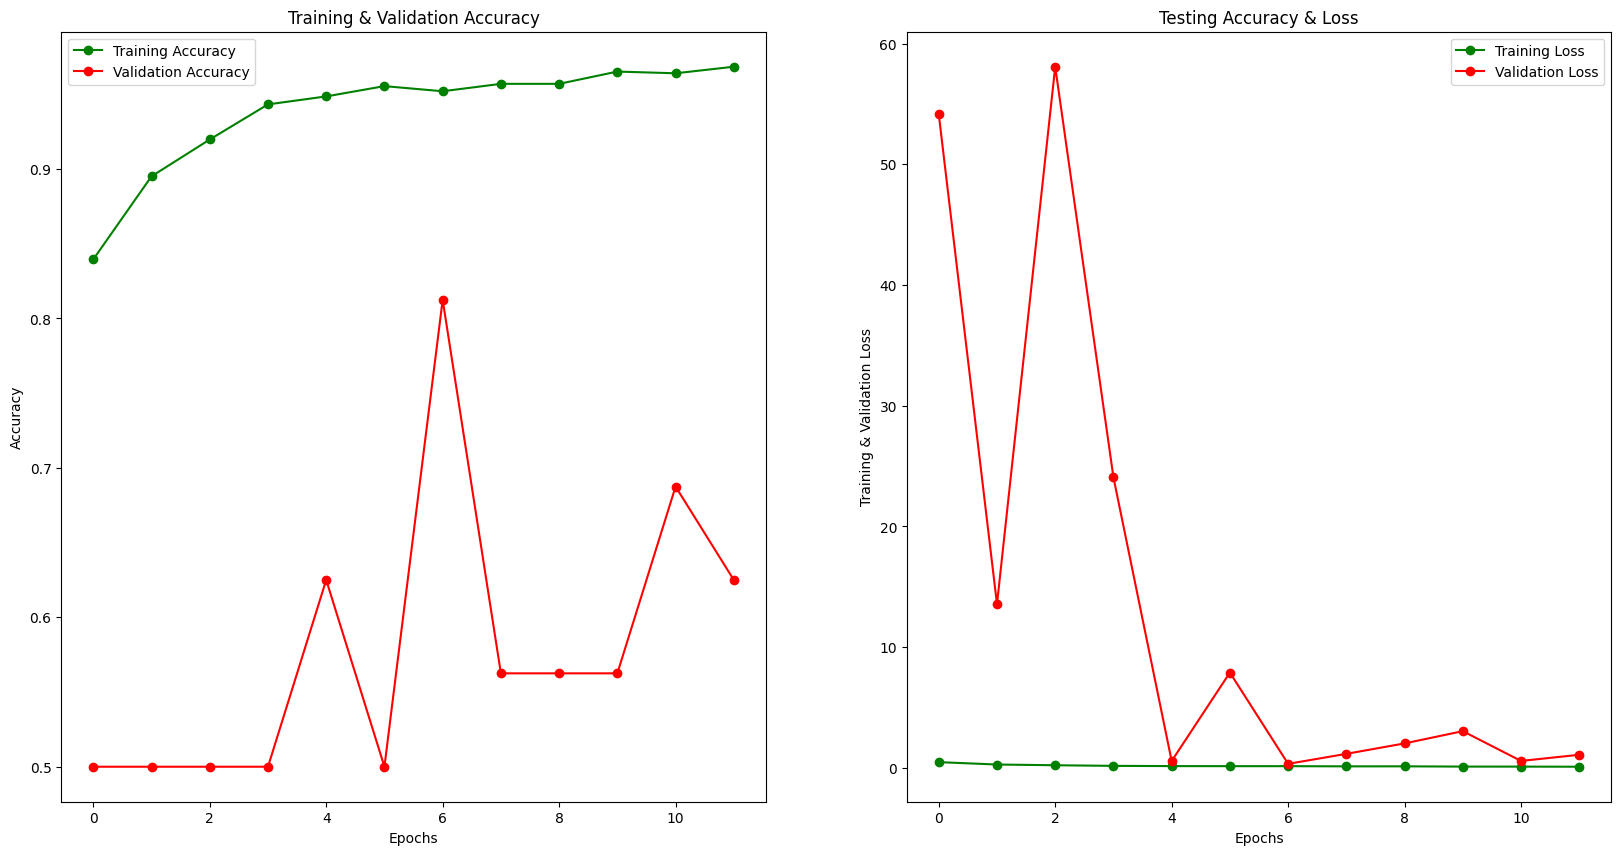

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

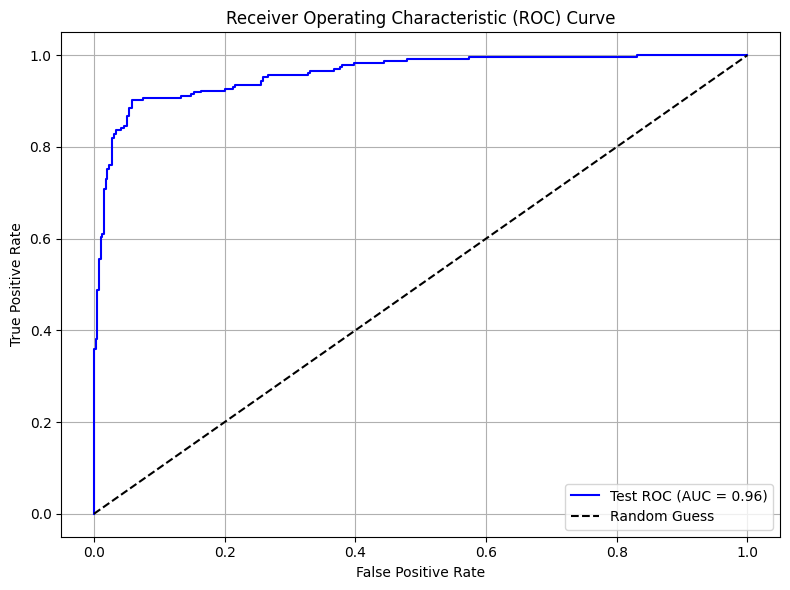

Train Accuracy: 0.9085
Test Accuracy: 0.9247

Classification Report (Test Set):
Precision: 0.9013
Recall: 0.8974
F1 Score: 0.8994
ROC AUC: 0.9597


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def get_predictions(X, y, model):
    y_pred_prob = model.predict(X, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    return y, y_pred, y_pred_prob.flatten()


train_true, train_pred, train_prob = get_predictions(X_train, y_train, model)
test_true, test_pred, test_prob = get_predictions(X_test, y_test, model)

fpr_test, tpr_test, _ = roc_curve(test_true, test_prob)
roc_auc_test = auc(fpr_test, tpr_test)


plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

metrics = {
    'train': {
        'accuracy': accuracy_score(train_true, train_pred),
        'precision': precision_score(train_true, train_pred),
        'recall': recall_score(train_true, train_pred),
        'f1': f1_score(train_true, train_pred),
    },
    'test': {
        'accuracy': accuracy_score(test_true, test_pred),
        'precision': precision_score(test_true, test_pred),
        'recall': recall_score(test_true, test_pred),
        'f1': f1_score(test_true, test_pred),
        'roc_auc': roc_auc_test
    }
}

print(f"Train Accuracy: {metrics['train']['accuracy']:.4f}")
print(f"Test Accuracy: {metrics['test']['accuracy']:.4f}")
print(f"\nClassification Report (Test Set):")
print(f"Precision: {metrics['test']['precision']:.4f}")
print(f"Recall: {metrics['test']['recall']:.4f}")
print(f"F1 Score: {metrics['test']['f1']:.4f}")
print(f"ROC AUC: {metrics['test']['roc_auc']:.4f}")
